<a href="https://colab.research.google.com/github/Navid-visual/Mixed-integer-ink-selection/blob/Semih/8_ink_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

Connect Colab to google drive to access the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install and import the reqiuered dependencies.

In [ ]:
import numpy as np
import torch
import os

from layer_config_forward_oracle import MultiLayerPerceptron_forward
import scipy.io as sio

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

!pip install colormath

from colormath.color_objects import sRGBColor, XYZColor
from colormath.color_conversions import convert_color

from scipy import ndimage

Navigate to the correct folder.

In [ ]:
os.chdir('/content/drive/MyDrive/Colab_for_uncertainty')
!pwd
!ls

Load the oracle model. oracle is an ensemble of 20 different networks.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)
# Load the forward model
input_size = 8
hidden_size = [100,250,250,100]
num_classes = 31
Models = []
for n_net in range(20):
    Oracle_model = MultiLayerPerceptron_forward(input_size, hidden_size, num_classes)
    # Oracle_model.load_state_dict(torch.load('Toy_net_%d.ckpt' %(n_net)))
    Oracle_model.load_state_dict(torch.load('Oracle_Epson_printer/models/mu_net_%d.ckpt' %(n_net)))
    # Oracle_model.to(device)
    Models.append(Oracle_model)

Using device: cuda


Convert spectra to XYZ

In [ ]:
def sp2xyz(s, lightsource, xbar, ybar, zbar):
  #  Copyright EPFL-LSP
  #  Derived from version 2005 (R.D Hersch / F. Crï¿½tï¿½)
  #  {r-spectrum, Illuminant} --> XYZ
  #  The input spectrum s can be a vector or a n x 36 spectra matrix.
  #  With sa n x 36 input matrix, a n x 3 output matrix is produced with one XYZ 
  #   value for each spectrum row of the input matrix, EP, RDH, 1.3.03
  k = 100 / np.matmul(lightsource, ybar.T)
  # Element wise multiplication of each row by the illuminant
  Vs = np.multiply(s , np.kron(np.ones((s.shape[0], 1)), lightsource))
  # Producing final XYZ value by dot products between _bar predefined
  # values & previosly computed Vs
  apended_xyz_bar = np.append(xbar.T, ybar.T, axis=1)
  apended_xyz_bar = np.append(apended_xyz_bar, zbar.T, axis=1)
  XYZ = np.matmul(np.multiply(k, Vs) , apended_xyz_bar)
  return XYZ

Convert XYZ to RGB

In [ ]:
def xyz2rgb(xyz):
  RGB = []

  for xyz_list in xyz:
        xyz = XYZColor(*[component/100 for component in xyz_list])
        rgb = convert_color(xyz, sRGBColor)
        rgb_list = [255*color for color in rgb.get_value_tuple()]
        RGB.append(rgb_list)

  RGB = np.asarray(RGB)
  return RGB

Calculate oracle performance for the input designs.

In [ ]:
def oracle_performace_for_design(designs):
  noisy_indices = (0.4<designs[:,3])
  designs[designs<0] = 0
  designs[designs>1] = 1

  designs = torch.tensor(designs).float()


  reproduced_spec_mu = torch.empty(designs.shape[0], num_classes)
  reproduced_spec_sigma = 0
  batch_size = 50000
  design_size = designs.shape[0]
  for batch_n in range(int(np.ceil(design_size/batch_size))):
      print(batch_n)
      reproduced_spec_ensembel = torch.empty(20, designs[batch_n*batch_size:(batch_n+1)*batch_size].shape[0], num_classes)

      for net_n in range(20):
          reproduced_spec = Models[net_n](designs[batch_n*batch_size:(batch_n+1)*batch_size])
          reproduced_spec_ensembel[net_n,:, :] = reproduced_spec

      reproduced_spec_mu[batch_n*batch_size:(batch_n+1)*batch_size] = (1 / 20) * torch.sum(reproduced_spec_ensembel, 0)
      reproduced_spec_mu = np.array(reproduced_spec_mu.detach())
      reproduced_spec_mu[noisy_indices > 0, :] = reproduced_spec_mu[noisy_indices > 0, :] + np.random.randn(
          noisy_indices.sum(), 31) / 10
  return reproduced_spec_mu

Constant values requiered for color conversion.

In [ ]:
D65 = np.array([[49.98,  54.65,  82.75,  91.49,  93.43,  86.68,  104.86, 117.01, 117.81,\
        114.86, 115.92, 108.81, 109.35, 107.8,  104.79, 107.69, 104.41, 104.05,\
        100.,   96.33,  95.79,  88.69,  90.01,  89.6,   87.7,   83.29,  83.7,\
        80.03,  80.21,  82.28,  78.28,  69.72,  71.61,  74.35,  61.6,   69.89 ]])

xbar = np.array([[0.0014, 0.0042, 0.0143, 0.0435, 0.1344, 0.2839, 0.3483, 0.3362, 0.2908,\
        0.1954, 0.0956, 0.0320, 0.0049, 0.0093, 0.0633, 0.1655, 0.2904, 0.4334,\
        0.5945, 0.7621, 0.9163, 1.0263, 1.0622, 1.0026, 0.8544, 0.6424, 0.4479,\
        0.2835, 0.1649, 0.0874, 0.0468, 0.0227, 0.0114, 0.0058, 0.0029, 0.0014]])
        
ybar = np.array([[0.0000, 0.0001, 0.0004, 0.0012, 0.0040, 0.0116, 0.0230, 0.0380, 0.0600,\
        0.0910, 0.1390, 0.2080, 0.3230, 0.5030, 0.7100, 0.8620, 0.9540, 0.9950,\
        0.9950, 0.9520, 0.8700, 0.7570, 0.6310, 0.5030, 0.3810, 0.2650, 0.1750,\
        0.1070, 0.0610, 0.0320, 0.0170, 0.0082, 0.0041, 0.0021, 0.0010, 0.0005]])
        
zbar = np.array([[0.0065, 0.0201, 0.0679, 0.2074, 0.6456, 1.3856, 1.7471, 1.7721, 1.6692,\
        1.2876, 0.813,  0.4652, 0.272,  0.1582, 0.0782, 0.0422, 0.0203, 0.0087,\
        0.0039, 0.0021, 0.0017, 0.0011, 0.0008, 0.0003, 0.0002, 0.,     0.,    \
        0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.    ]])
refwhiterefl = np.ones((1,31)); 
lightsource = D65[0:1,2:33]; 

Load the results of the NA inversion and calculate the oracle performance for its designs. Find the samples that lie in the noisy region and add the noise.

0


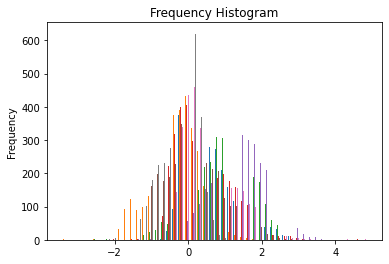

In [ ]:
mat = sio.loadmat('NA/Results/NA_design.mat')
designs = mat['NA_design']

#plot the distribution of the design values
plt.hist(designs, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

#calculate the oracle performance on the designs
reproduced_spec_mu_NA = oracle_performace_for_design(designs)
sio.savemat('NA/Results/Oracle_performance_for_NA_designs.mat', {'Oracle_performance_for_NA_designs':reproduced_spec_mu_NA})

Load the results of the UA inversion and calculate the oracle performance for its designs. Find the samples that lie in the noisy region and add the noise.

0


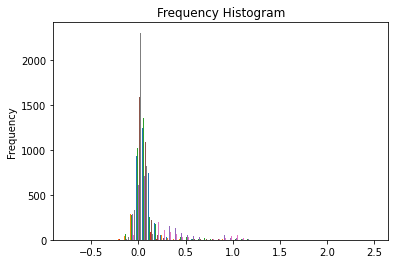

In [ ]:
mat = sio.loadmat('UANA/Results/UANA_design.mat')
designs = mat['UANA_design']

#plot the distribution of the design values
plt.hist(designs, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

#calculate the oracle performance on the designs
reproduced_spec_mu_UANA = oracle_performace_for_design(designs) 
sio.savemat('UANA/Results/Oracle_performance_for_UANA_designs.mat', {'Oracle_performance_for_UANA_designs':reproduced_spec_mu_UANA})

Load the indexes of the painting. The index uses the color map as a look up tabel to determin the color of each pixle. 

In [ ]:
mat = sio.loadmat('couple_approx_spec_map.mat')
image_index=mat['IND']
image_index = ndimage.rotate(image_index,180)

Convert the spectral data to xyz and xyz to RGB.

In [ ]:
xyz_NA = sp2xyz(reproduced_spec_mu_NA, lightsource, xbar[0:1, 2:33], ybar[0:1, 2:33], zbar[0:1, 2:33])
rgb_NA = xyz2rgb(xyz_NA)

xyz_UANA = sp2xyz(reproduced_spec_mu_UANA, lightsource, xbar[0:1, 2:33], ybar[0:1, 2:33], zbar[0:1, 2:33])
rgb_UANA = xyz2rgb(xyz_UANA)


Plot the results for the oracle performance for the design calculated using diffferent inversions.

In [ ]:
def print_painting(rgb):
  rgb_append = np.append(rgb, np.ones((rgb.shape[0], 1))*256, axis = 1)
  rgb_append[rgb_append>255] = 255

  rgb_colormat = ListedColormap(rgb_append/256)
  print(rgb_append.max())
  psm = axs.pcolormesh(image_index, cmap=rgb_colormat, rasterized=True)
  return axs

NA results

255.0


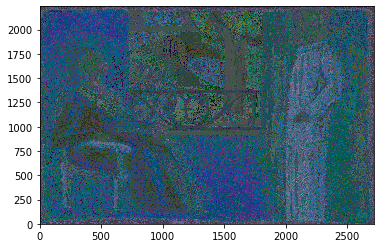

In [ ]:
fig, axs = plt.subplots(1,1)
print_painting(rgb_NA)
plt.show()

UANA results

255.0


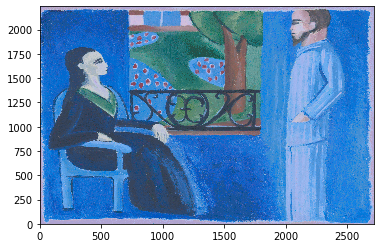

In [ ]:
fig, axs = plt.subplots(1,1)
print_painting(rgb_UANA)
plt.show()